In [18]:
from drawDot import DrawDot

In [40]:
class Value:
    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad*1.0
            other.grad += out.grad*1.0
        out._backward = _backward
        return out
        

    #a+b = c dc/da = 1 exp(c) = d dd/da = dd/dc * dc/da = 

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')
        def _backward():
            self.grad += out.grad*1.0
            other.grad += out.grad*-1.0
        out._backward = _backward
        return out

    def __rsub__(self, other):
        return self - other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += out.grad*other.data
            other.grad += out.grad*self.data
        out._backward = _backward
        return out

    def __rsub__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int and float"
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * (other ** -1)

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.grad* out.data
        out._backward = _backward
        return out

    def relu(self):
        out = Value(self.data if self.data >= 0 else 0.0, (self, ), 'ReLU')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        #topographical sorting L->R ordering of all elements
        topo = []
        visited = set()
        def build_topo(v): #what shall be the initial value
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        



In [41]:
a = Value(3.0, label = 'a')
b = Value(9.0, label = 'b')
c = a + b
x = c.relu()
y = pow(x,10)
L = y.relu()

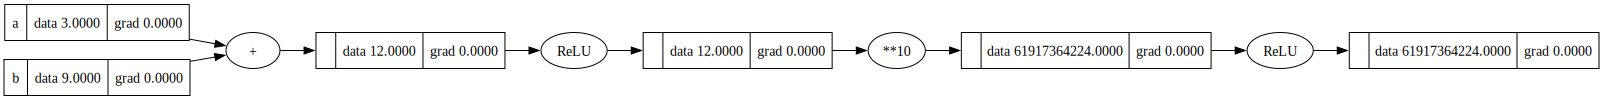

In [42]:
draw_dot(L)